In [1]:
import json
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
from itertools import chain, combinations
from pathlib import Path
from climdist.data import load as load_df
from wordcloud import WordCloud
import matplotlib.font_manager as fm

In [2]:
class Analyse():
    
    def __init__(self):
        
        print('Importing main dataframe')
        self.df = load_df('main', readability=True, heading2=True)
        self.df = self.df[self.df.readability==True]
        
        print('Importing processed articles')
        self.sentences = list(self.load_sentences())
        
        print('Importing detected keywords')
        with open('../data/processed/all_keywords_100522.json', 'r', encoding='utf') as f:
            self.keywords = json.load(f)
            
        print('Importing auxiliaries')
        self.ruler = pd.read_excel('../pipeline/ner/ruler_patterns_060522.xlsx', index_col='Unnamed: 0')
        self.wea_df = pd.read_csv('../data/processed/wea_df_010522.tsv', sep='\t', encoding='utf8', index_col=0)
        self.wordform_df = pd.read_csv('../data/processed/wordform_df_010522.tsv', sep='\t', encoding='utf8', index_col=0)
        self.phenomenon_df = pd.read_csv('../data/processed/phenomenon_df_110522.tsv', sep='\t', encoding='utf8', index_col=0)
        
        self.ix_to_year = self.df['year'].to_dict()
            
        self.font_path = '../references/cmunorm.ttf'
        fm.fontManager.addfont(self.font_path)
        
    def wordform_to_key(self, wordform):
        return list(self.ruler.key[self.ruler.wordform == wordform].unique())
    
    def phenomenon_to_key(self, phenomenon):
        return list(self.ruler.key[self.ruler.phenomenon == phenomenon].unique())
    
    def phenomenon_to_wordform(self, phenomenon):
        return list(self.ruler.wordform[self.ruler.phenomenon == phenomenon].unique())
        
    def load_sentences(self):
        with open('../data/processed/RZ_sentences.jsonl', 'r', encoding='utf8') as f:
            for ix, line in tqdm(enumerate(f.readlines())):
                yield json.loads(line)
                
                
    def ids_by_kw(self, keys, timerange, index_filter=None): 
        """Returns indexes of all entites that contain a certain keyword"""
    
        if index_filter is None:
            index_filter = self.df.index
        keys=set(keys)
        results = []
        
        for sentence, entry in zip(self.sentences, self.keywords):
            if sentence['id'] in index_filter \
            and len(entry['ents']) > 0 \
            and self.df.loc[sentence['id'], 'year'] in timerange \
            and len(set([ent[0] for ent in entry['ents']]) & keys) > 0: 
                    results.append(sentence['id'])
                    
        return results
    
    
    def headings_by_kw(self, words, timerange=range(1802,1889), phenomenon=False): 
        """Returns a pd.Series.value_counts() object of headings of articles that contain a given keyword"""
    
        if phenomenon == True:
            keys = set(self.ruler.key[self.ruler.phenomenon.isin(words)])
        else:
            keys = set(self.ruler.key[self.ruler.wordform.isin(words)])    
        ids = self.ids_by_kw(keys, timerange)
        
        return self.df.heading2.loc[ids].value_counts()
    
    
    def word_context(self, word, window, index_filter=None, phenomenon=False):
        """Input: wordform. Returns a list of context words in a defined window"""
    
        if index_filter is None:
            index_filter = self.df.index
        if phenomenon == True:
            keys = self.phenomenon_to_key(word)
        else:
            keys = self.wordform_to_key(word)
            
        results = []
        
        for sentence, entry in tqdm(zip(self.sentences, self.keywords)):
            if sentence['id'] in index_filter:
                if len(entry['ents']) > 0:
                    for ent in entry['ents']:
                        if ent[0] in keys:
                            ix = ent[1]
                            context_before = sentence['text'][ix-window:ix]
                            context_after  = sentence['text'][ix+1:ix+window]
                            results.extend(context_before + context_after)
           
        return results
    
    
    def keyword_plot(self, keywords, cat='wordform', kind='line', wordform=True, relative=True, savepath=None, **kwargs):
    
        if cat == 'key':
            plot_df = self.wea_df
        elif cat == 'wordform':
            plot_df = self.wordform_df
        elif cat == 'phenomenon':
            plot_df = self.phenomenon_df
        else:
            return('Please select a valid CAT')
        
        matplotlib.rcParams['font.family'] = 'CMU Concrete'
        col = sns.color_palette("muted", len(keywords))
        plt.figure(figsize=(15,7))
        ticksrange = np.arange(1802,1890)
        xlabels = [num if num%5==0 else '' for num in np.arange(1802,1890)]
        
        ### lineplots
        if kind == 'line':
            if relative:
                for word in keywords:
                    plt.plot(plot_df[word]/plot_df.total, label=word)             
            else:
                for word in keywords:
                    plt.plot(plot_df[word], label=word)
                
        ### stackplots            
        if kind == 'stack':
            if relative == True:
                plt.stackplot(np.arange(1802,1889),
                              [plot_df[word]/plot_df.total for word in keywords],
                              labels=keywords,
                              colors=col)
            else:
                plt.stackplot(np.arange(1802,1889), [plot_df[word] for word in keywords], labels=keywords)    
        
        plt.grid(b=True, which='both')
        plt.yticks(fontsize=14)
        plt.xticks(ticks=ticksrange, labels=xlabels, fontsize=14)
        plt.tick_params(axis ='x', rotation = 45)
        plt.setp(plt.gca().spines.values(), color='black')
        plt.gca().set_frame_on(True)
        
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles[::-1], labels[::-1], fontsize=12, **kwargs)
    
        if relative == True:
            plt.ylabel("part de tous les mots-clés", fontsize=18)
        else:
            plt.ylabel("nb. d'occurrences", fontsize=18)
            
        sns.set_style(style='whitegrid')
        
        if savepath:
            plt.savefig(savepath, bbox_inches='tight')
        
        plt.show()
        
        
    def context_wordcloud(self, context_words, savepath=None):
    
        wordcloud_data = ' '.join([word for word in context_words])
        
        print(f'Generated from {len(wordcloud_data.split())} context words')
        wc = WordCloud(background_color='white', width=900, height=300, font_path='../references/cmunrm.ttf')
        wc.generate(wordcloud_data)
        plt.figure(figsize=(12,4))
        plt.axis('off')
        
        plt.imshow(wc)
        if savepath:
            plt.savefig(savepath, bbox_inches='tight')
        plt.show()
                    

In [3]:
an = Analyse()

Importing main dataframe
Importing processed articles


0it [00:00, ?it/s]

Importing detected keywords
Importing auxiliaries


In [4]:
### LaTex table of most popular entities

dist_half1 = an.wea_df[an.wea_df.columns[1:26]].sum().to_frame().reset_index()
dist_half2 = an.wea_df[an.wea_df.columns[26:51]].sum().to_frame().reset_index()
dist = pd.concat([dist_half1, dist_half2], axis=1)
dist
#print(dist.to_latex(index=False))

,index,0,index,0
0,sturm,7185,winden,763
1,regen,6873,unwetter,745
2,wetter,6468,bewölkter_himmel,716
3,witterung,5711,wolke,708
4,schnee,4624,sturmes,639
5,wind,4520,kühle,631
6,kälte,3595,regengüsse,625
7,hitze,3319,schneefall,599
8,wärme,3051,überschwemmung,582
9,winde,3023,grad_kälte,537


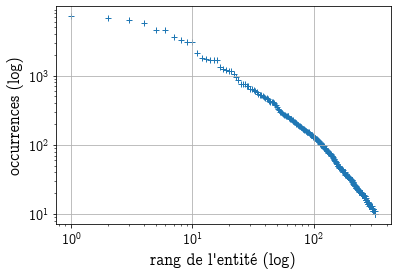

In [5]:
matplotlib.rcParams['font.family'] = 'CMU Concrete'
plt.figure(figsize=(6,4))

counts = an.wea_df.loc[:, an.wea_df.columns != 'total'].sum(axis=0).sort_values(ascending=False).values
ranks = range(1, len(counts)+1)

plt.scatter(ranks, counts, s=30, marker='+', linewidth=1)
plt.xticks(ticks=[num for num in ranks if num%10==0].insert(0,1), 
           labels=[str(num) for num in ranks if num%10==0].insert(0,1), fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('occurrences (log)', fontsize=16)
plt.xlabel("rang de l'entité (log)", fontsize=16)

plt.yscale('log')
plt.xscale('log')

plt.grid()
sns.set_style('ticks')
#plt.savefig('../references/memoire/images/zipf.pdf', bbox_inches='tight')
plt.show()

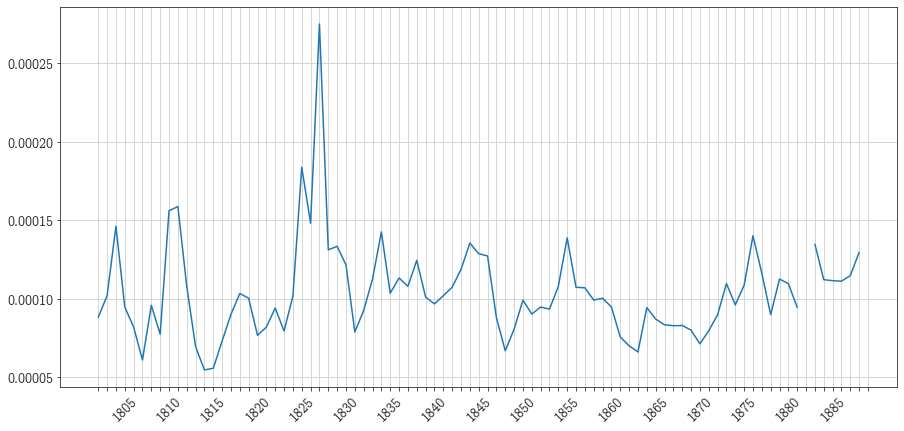

In [6]:
matplotlib.rcParams['font.family'] = 'CMU Concrete'
ticksrange = np.arange(1802,1890)
xlabels = [num if num%5==0 else '' for num in np.arange(1802,1890)]

fig = plt.figure(figsize=(15,7))
(an.wea_df.total/an.df.groupby('year')['text_len'].sum().reindex(range(1802,1889)).fillna(0)).plot() # insert .rolling(5, min_periods=1).mean() before plot for rolling average
plt.grid(b=True, which='both')
plt.yticks(fontsize=14)
plt.xticks(ticks=ticksrange, labels=xlabels, fontsize=14)
plt.tick_params(axis ='x', rotation = 45)

#plt.title("Nb. d'entités par rapport à la masse total de texte", fontsize=20)
#plt.ylabel("Nb. d'articles", fontsize=20)
#plt.legend(fontsize = 14)
sns.set_style(style='ticks')

#plt.savefig('../references/memoire/images/entities_per_mass.pdf', bbox_inches='tight')

plt.show()

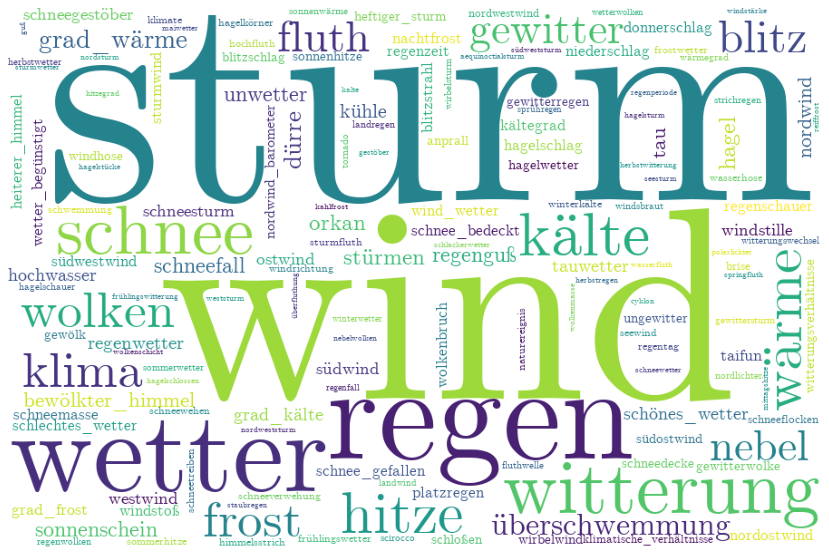

In [7]:
wea_freqs = {key: value for (key, value) in
             sorted(an.wordform_df.loc[:, an.wordform_df.columns != 'total'].sum().to_dict().items(),
             key=lambda x:x[1], reverse=True)}
wea_freqs_early = an.wordform_df.loc[:1859, an.wordform_df.columns != 'total'].sum().to_dict()
wea_freqs_late = an.wordform_df.loc[1860:, an.wordform_df.columns != 'total'].sum().to_dict()

wc = WordCloud(background_color='white', width=900, height=600, font_path='../references/cmunrm.ttf')
wc.generate_from_frequencies(wea_freqs)
plt.figure(figsize=(15,10))
plt.axis('off')

plt.imshow(wc)
#plt.savefig('../references/memoire/images/wordcloud_general.pdf', bbox_inches='tight')
plt.show()

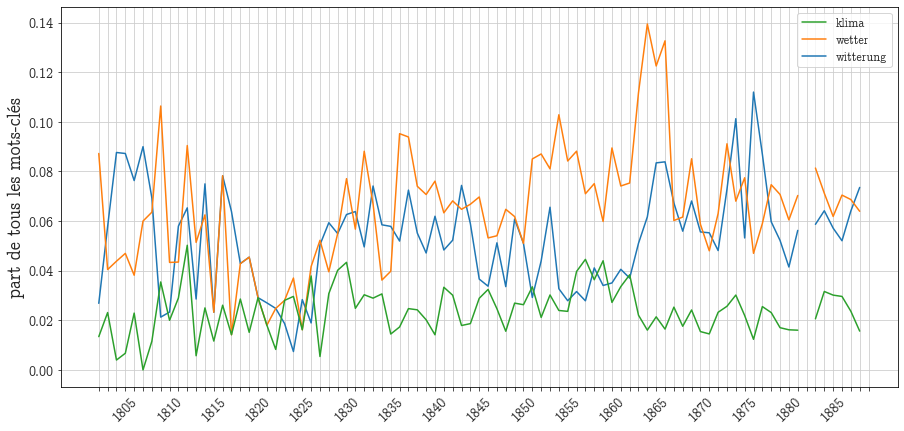

In [8]:
an.keyword_plot(['witterung', 'wetter', 'klima'], kind='line')
           #savepath='../references/memoire/images/wetter_witterung_klima.pdf')

In [9]:
an.headings_by_kw(['wetter'], range(1864,1867))[:10]

Börsen- und Handels-Nachrichten     229
Börsen-und Handels-Nachrichten       32
Locales                              14
Deutschland                          11
Börsen- und Handels- Nachrichten     11
Vermischtes                          10
London                               10
Inland                                9
Berlin                                8
Berliner Briefe                       7
Name: heading2, dtype: int64

0it [00:00, ?it/s]

Generated from 2256 context words


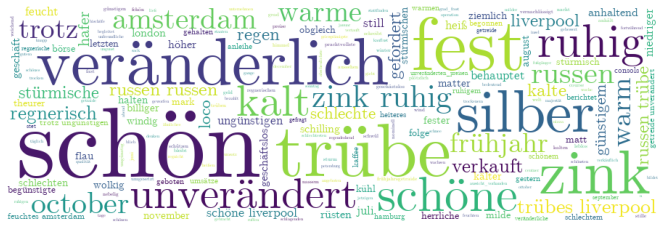

In [10]:
wetter_context = an.word_context('wetter', 2, index_filter=an.df.loc[an.df.year.isin(range(1864,1867))].index)
an.context_wordcloud(wetter_context)

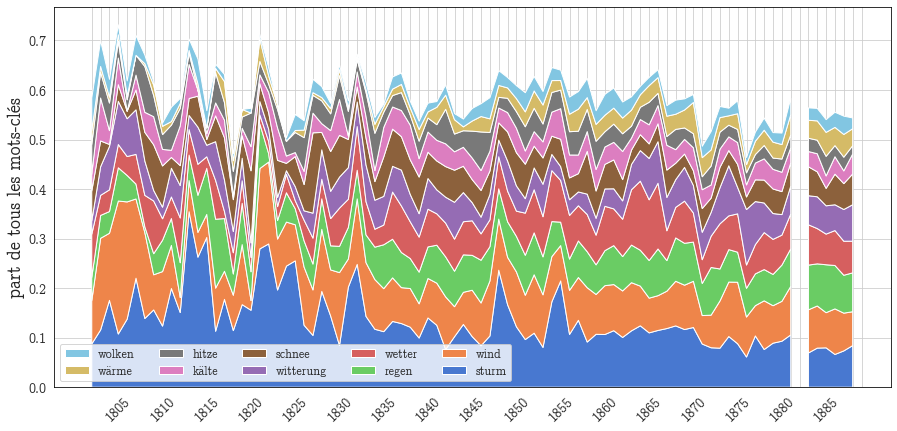

In [11]:
an.keyword_plot([word for word in an.wordform_df.columns[1:]][:10],
               cat='wordform',kind='stack',relative=True,
               loc='lower left', ncol=5)
               #savepath='../references/memoire/images/10_most_frequent_ents.pdf'

## Orkan, Taifun, Tornado, Scirocco

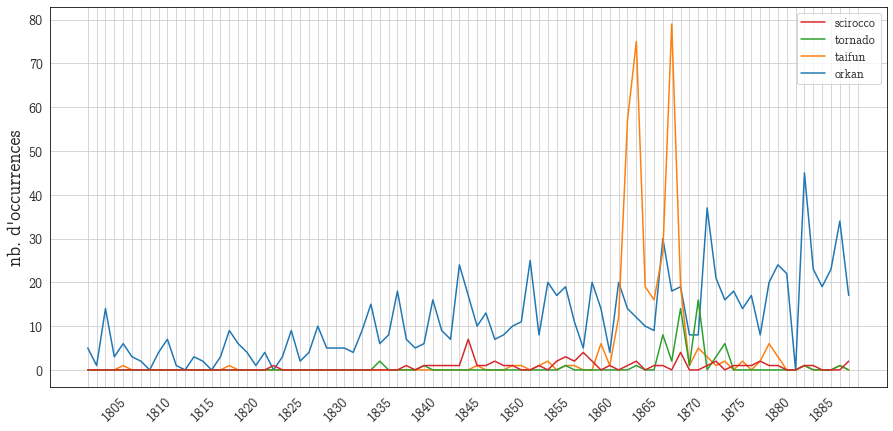

In [12]:
an.keyword_plot(['orkan', 'taifun', 'tornado', 'scirocco'],
                kind='line', relative=False)
                #savepath='../references/memoire/images/orkan_taifun_tornado.pdf')

### Taifun

In [13]:
### under which headings is "taifun" most often mentioned?
an.headings_by_kw(['taifun'], range(1860,1870))[:20]

Asien                                                 26
Neueste Nachrichten                                   16
Japan                                                 12
Frankreich                                             8
Rundschau am politischen Horizont des Sonnenaufgan     6
London                                                 5
Inland                                                 4
Inhalt                                                 3
Deutschland                                            3
Paris                                                  2
Frankfurt a. M.                                        2
Wien                                                   1
Inländische Nachrichten. Inländische Nachrichte«       1
PariS                                                  1
Riga, 14 Februar. In der Russ. „St. P.A." hatte ei     1
P4riS                                                  1
Japan. Aus Yokohama, 12. Zuni. wird gemeldet: Der      1
Clnna. Der „Moniteur" giebt ein

### Scirocco

In [14]:
### under which headings is "scirocco" most often mentioned?
an.headings_by_kw(['scirocco'])[:15]

Italien                                               7
Wien                                                  2
Neapel                                                2
Oesterreich                                           2
Vermischtes                                           2
Eine Brünhilde                                        1
Berlin                                                1
Ueber die Verheerungen, welche der bereits tele« g    1
Asien                                                 1
Lissa                                                 1
Florenz                                               1
— (Der Sirocco.) Am 10. März Morgens, schreibt man    1
Deutsches Reich                                       1
Riga, 13. Februar. Ueber die Stellung der Gouverne    1
Dulcigno                                              1
Name: heading2, dtype: int64

In [15]:
### are there news that talk exclusively about the Scirocco?
an.df.loc[an.df.heading2.str.contains('Sirocco|Scirocco', na=False), ['date', 'heading2']]

,date,heading2
128124,1855-10-19,Rom. (Zeit.) In Rom hat der hestig wehende Sir...
128224,1855-10-27,(Zeit.) Bei ungewöhnlich heftigem Siroccowinde...
190735,1869-04-08,"— (Der Sirocco.) Am 10. März Morgens, schreibt..."


## Hagel

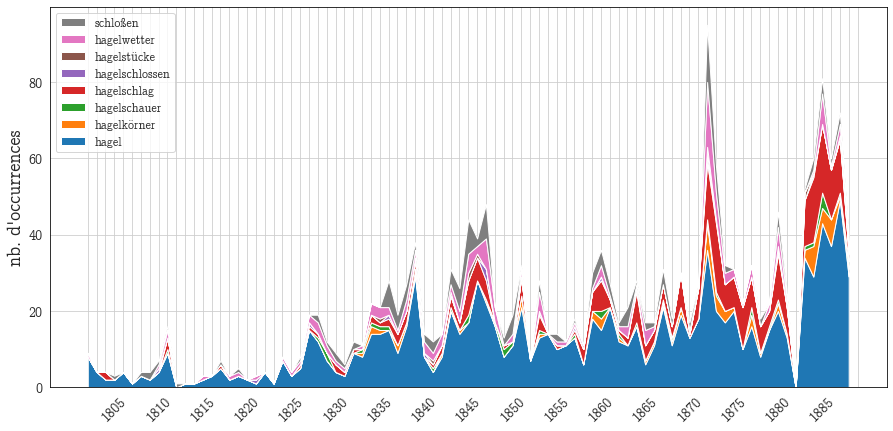

In [24]:
hagel_wordforms = an.ruler.wordform[an.ruler.phenomenon == 'hagel'].unique()
an.keyword_plot(hagel_wordforms, cat='wordform', kind='stack', relative=False, loc='upper left')
                #savepath='../references/memoire/images/hagel.pdf')

In [17]:
### under which headings is "hagel" most often mentioned?
an.headings_by_kw(['hagel'], phenomenon=True)

Inland                                                200
Vermischtes                                            63
Paris                                                  44
St. Petersburg                                         23
Deutschland                                            22
                                                     ... 
Aus Verfügung Eines Edlen Vogtei – Gerichts werden      1
Das grosze und das kleine Loos                          1
Wie«, 17. August. (H, E.). Dem Schicksal des zu fr      1
Auf dein Original des folgenden Berichts ist von S      1
Riga. 22. November                                      1
Name: heading2, Length: 633, dtype: int64

0it [00:00, ?it/s]

Generated from 2676 context words


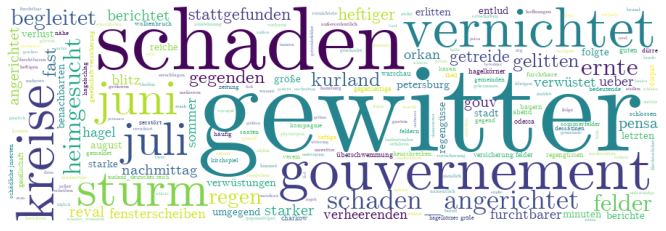

In [23]:
hagelschlag_context = an.word_context('hagelschlag', 5, phenomenon=False)
an.context_wordcloud(hagelschlag_context)
                    #savepath='../references/memoire/images/wordcloud_hagelschlag.pdf')

In [19]:
### analyse the 1872 peak

hagel_entries = {}
for entry in an.keywords:
    if an.ix_to_year[entry['id']] in range(1872,1873):
        hagel_entries[entry['id']] = len([kw[0] for kw in entry['ents'] if kw[0] in an.ruler.key[an.ruler.phenomenon=='hagel'].values])
hagel_entries = {key: value for key, value in sorted(hagel_entries.items(), key=lambda x: x[1], reverse=True)}
hagel_filter = [key for key, value in hagel_entries.items() if value > 5]

In [27]:
most_hagel_mentions1 = list(hagel_entries.keys())[0]
most_hagel_mentions2 = list(hagel_entries.keys())[1]

print(an.df.loc[most_hagel_mentions1, ['date', 'heading2']].values)
print('keywords in article:\n',
      ', '.join([kw[0] for kw in [entry for entry in an.keywords if entry['id'] == most_hagel_mentions1][0]['ents']]))
print(len([kw[0] for kw in [entry for entry in an.keywords if entry['id'] == most_hagel_mentions2][0]['ents']]))
print('\n')
print(an.df.loc[most_hagel_mentions2, ['date', 'heading2']].values)
print('keywords in article:\n',
      ', '.join([kw[0] for kw in [entry for entry in an.keywords if entry['id'] == most_hagel_mentions2][0]['ents']]))
print(len([kw[0] for kw in [entry for entry in an.keywords if entry['id'] == most_hagel_mentions2][0]['ents']]))

['1872-05-13' 'Das Unwetter vom 10. Mai']
keywords in article:
 unwetter, hagelschlag, hagelwetter, hagel, hagelkörner, schlossen, schnee, hagelkörner, hagelkörner, gewitterwolken, sturm, wolken, hagelkörner, windhose, windsbraut, gewitter, wärme, sturm, windsbraut, ungewitter, wetter, gewittern, wolken, schlossen, unwetter, sturmes, hagel, wetter, hagelstücke, wetter, regen
36


['1872-05-19' 'Die Windhofe und das Hagelwetter am 10. Mai 1872,']
keywords in article:
 hagelwetter, gewitter, witterung, nordwind, nordwestwind, regen, wind, gewitterwolke, regen, sturm, hagel, orkan, hagel, güsse, gewitter, hagel, hagelkörner, wolkenmassen, sturmes, sturm, hagel, schnee, hagel, sturme, hagel, hagel, anprall, windhose, wolke, gewitterwolke, windhose, windhose, windhose, windhose, windhose, sturm
36


### Sturm

In [66]:
print(f'Mean frequency of "Sturm" in the corpus: {an.phenomenon_df.loc[np.r_[1802:1855, 1856:1882, 1883:1889],"sturm"].mean()}')
print(f'Frequency in 1855: {an.phenomenon_df.loc[1855, "sturm"]}')

Mean frequency of "Sturm" in the corpus: 161.12941176470588
Frequency in 1855: 457


In [63]:
print({an.phenomenon_df.loc[np.r_[1802:1855, 1856:1882, 1883:1889],'sturm'].mean()})

{161.12941176470588}


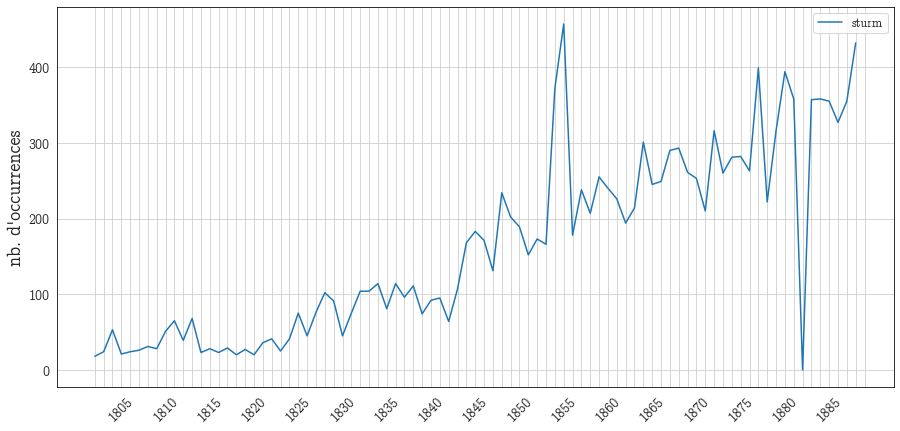

In [54]:
sturm_wordforms = an.ruler.wordform[an.ruler.phenomenon == 'sturm'].unique()
an.keyword_plot(['sturm'], cat='phenomenon', kind='line', relative=False,
                savepath='../references/memoire/images/sturm.pdf')

In [45]:
an.phenomenon_df.loc[1852:1860, 'sturm']

1852    173
1853    166
1854    372
1855    457
1856    178
1857    238
1858    207
1859    255
1860    240
Name: sturm, dtype: int64

In [48]:
an.headings_by_kw(['sturm'], range(1855,1856), phenomenon=True)[:20]

Orientalische Angelegenheiten    60
Inland                           18
Großbritannien und Irland        18
London                           12
Krim                              8
Newyork                           8
Wien                              6
Ostsee                            5
Deutschland                       4
Frankreich                        4
Sewastopol                        3
Paris                             3
Konstantinopel                    2
Kars                              2
Der Baigneur von Ostende          2
Nikolajew                         2
Brüssel                           2
Italien                           2
Oesterreich                       2
Varna                             1
Name: heading2, dtype: int64

0it [00:00, ?it/s]

Generated from 114585 context words


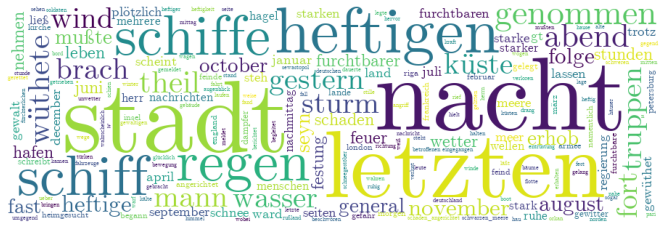

In [57]:
sturm_context = an.word_context('sturm', 5, phenomenon=True)
an.context_wordcloud(sturm_context)
                     #savepath='../references/memoire/images/wordcloud_sturm.pdf')

0it [00:00, ?it/s]

Generated from 3981 context words


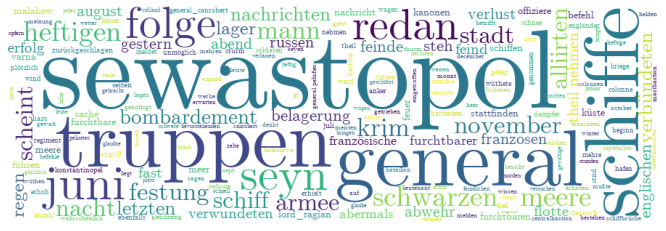

In [58]:
sturm_filter_1855 = [key for key, val in an.ix_to_year.items() if val == 1855]
sturm_context_1855 = an.word_context('sturm', 5, phenomenon=True, index_filter=sturm_filter_1855)
an.context_wordcloud(sturm_context_1855)
                     #savepath='../references/memoire/images/wordcloud_sturm_1855.pdf')